In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import glob
import momlevel

In [3]:
outdir='/work/jet/data/interim/'

frq = 'annual'
mods = ['CM4_historical_c192_OM4p125', 'CM4_historical_c192_OM4p25']
variables = ['ct', 'sa']
ddict = {mod:{} for mod in mods}
for i, mod in enumerate(ddict):
    for j, var in enumerate(variables):
        files = glob.glob(outdir+'%s_so_*_southof600S_asbw_%s_%s.nc'%(mod, var, frq))
        if len(files)>1:
            print('WARNING: More than one file for '+mod)
        elif len(files)==0:
            print('ERROR: No files found for variable %s in %s'%(var,mod))
            ddict[mod][var] = []
            continue
        print('Loading '+files[0])
        ddict[mod][var] =  xr.open_dataset(files[0])

Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_so_1850to1979_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p125_so_1850to1979_southof600S_asbw_sa_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_so_1850to2009_southof600S_asbw_ct_annual.nc
Loading /work/jet/data/interim/CM4_historical_c192_OM4p25_so_1850to2009_southof600S_asbw_sa_annual.nc


In [4]:
ds_ref = xr.open_dataset('/work/jet/Schmidtko_Antarctic_shelf_data.nc',
                                     decode_times=False, drop_variables=['depth'])
ds_ref = ds_ref.rename({'lon':'xh','lat':'yh'})
ds_ref['xh'].attrs['axis'] = 'X'
ds_ref['yh'].attrs['axis'] = 'Y'

# Create geolon/geolat
geolon, geolat = momlevel.util.tile_nominal_coords(ds_ref.xh, ds_ref.yh)
ds_ref['geolon'] = geolon
ds_ref['geolat'] = geolat

# Land mask
ds_ref['wet'] = xr.where(ds_ref.sa.isnull(),0.,1.).squeeze().rename('wet')

ddict['Schmidtko'] = ds_ref

In [5]:
yr_st, yr_ed = '1950', '1979'

## Stats

In [6]:
import xcompare as xc
from om4labs.om4common import standard_grid_cell_area

In [7]:
def horizontal_mean(varname, ds):
    num = (ds[varname] * ds['areacello'] * ds['wet']).sum(dim=['xh', 'yh'])
    denom = (ds['areacello'] * ds['wet']).sum(dim=['xh', 'yh'])
    return num / denom

In [8]:
dset_ref = 'Schmidtko'

yr_st, yr_ed = '1940', '1969'
ocean_coords = ['geolon', 'geolat', 'areacello', 'wet']
ds_ref = ddict[dset_ref].reset_coords()

# Generate areacello
ds_ref['areacello'] = xr.DataArray(standard_grid_cell_area(ds_ref.yh, ds_ref.xh), dims=('yh', 'xh'), 
                                   coords={'yh': ds_ref.yh.values, 'xh': ds_ref.xh.values})

In [9]:
var = 'ct'
horizontal_mean(var,ds_ref)

<xarray.DataArray ()>
array(-0.899198)

In [10]:
ds_ref[var].weighted(ds_ref.areacello).mean()

<xarray.DataArray 'ct' ()>
array(-0.899198)

In [11]:
da_ref = ds_ref[var]
da_ref['xh'].attrs['axis'] = 'X'
da_ref['yh'].attrs['axis'] = 'Y'
arr_ref = xc.coord_util.associate_ocean_coords(da_ref, ds_ref[ocean_coords], prefix=ocean_coords)

In [12]:
from xcompare import xr_stats

In [13]:
stats = []
bias = []
rmse = []

for i, dset in enumerate(ddict):
    print(dset)
    
    if dset==dset_ref:
        ds = ds_ref
        da = ddict[dset][var]
        da['xh'].attrs['axis'] = 'X'
        da['yh'].attrs['axis'] = 'Y'
    else:
        ds = ddict[dset][var]
        da = ds.sel(time=slice(yr_st, yr_ed)).mean('time')['bottom_'+var].rename(var)
    
    arr = xc.coord_util.associate_ocean_coords(da, ds[ocean_coords], prefix=ocean_coords)
    results = xc.compare_datasets(arr.to_dataset(), arr_ref.to_dataset(), varlist=[var])
    stats.append(xr_stats.xr_stats_2d(results['ds1'][var], results['ds2'][var], results['diff'].area, fmt='dict'))
    
    # calculate difference of arrays
    diff = results['ds2'][var] - results['ds1'][var]
    
    # calculate area-weighted bias
    bias.append(diff.weighted(results['diff'].area).mean())
    
    # rmse
    rse = np.sqrt(diff ** 2)
    rmse.append(rse.weighted(results['diff'].area).mean())

CM4_historical_c192_OM4p125
CM4_historical_c192_OM4p25
Schmidtko


In [14]:
import pandas as pd

In [15]:
pd.DataFrame(stats)

bias      rmse  rsquared
0  0.234414  0.471305   0.85002
1 -0.040012  0.467719   0.79106
2  0.000000  0.000000   1.00000

In [16]:
xr.concat(bias,pd.Index(list(ddict), name='dset')).to_dataframe(name='bias')

bias
dset                                 
CM4_historical_c192_OM4p125 -0.234415
CM4_historical_c192_OM4p25   0.040012
Schmidtko                    0.000000

In [17]:
xr.concat(rmse,pd.Index(list(ddict), name='dset')).to_dataframe(name='rmse')

rmse
dset                                 
CM4_historical_c192_OM4p125  0.471305
CM4_historical_c192_OM4p25   0.467719
Schmidtko                    0.000000

## Maps

In [18]:
import cmocean.cm as cmo
import cartopy
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/home/Jan-erik.Tesdal/wmt-inert-tracer/scripts/tools')
from plot import get_so_map_boundary
circle = get_so_map_boundary()

In [19]:
from mplsettings import setup_plots
setup_plots()

In [20]:
titstr = ['CM4X-p125 hist (%s-%s)'%(yr_st,yr_ed), 'CM4X-p25 hist (%s-%s)'%(yr_st,yr_ed), 'Schmidtko (1975–2012)']

CM4_historical_c192_OM4p125 ct
CM4_historical_c192_OM4p125 sa
CM4_historical_c192_OM4p25 ct
CM4_historical_c192_OM4p25 sa
Schmidtko ct
Schmidtko sa


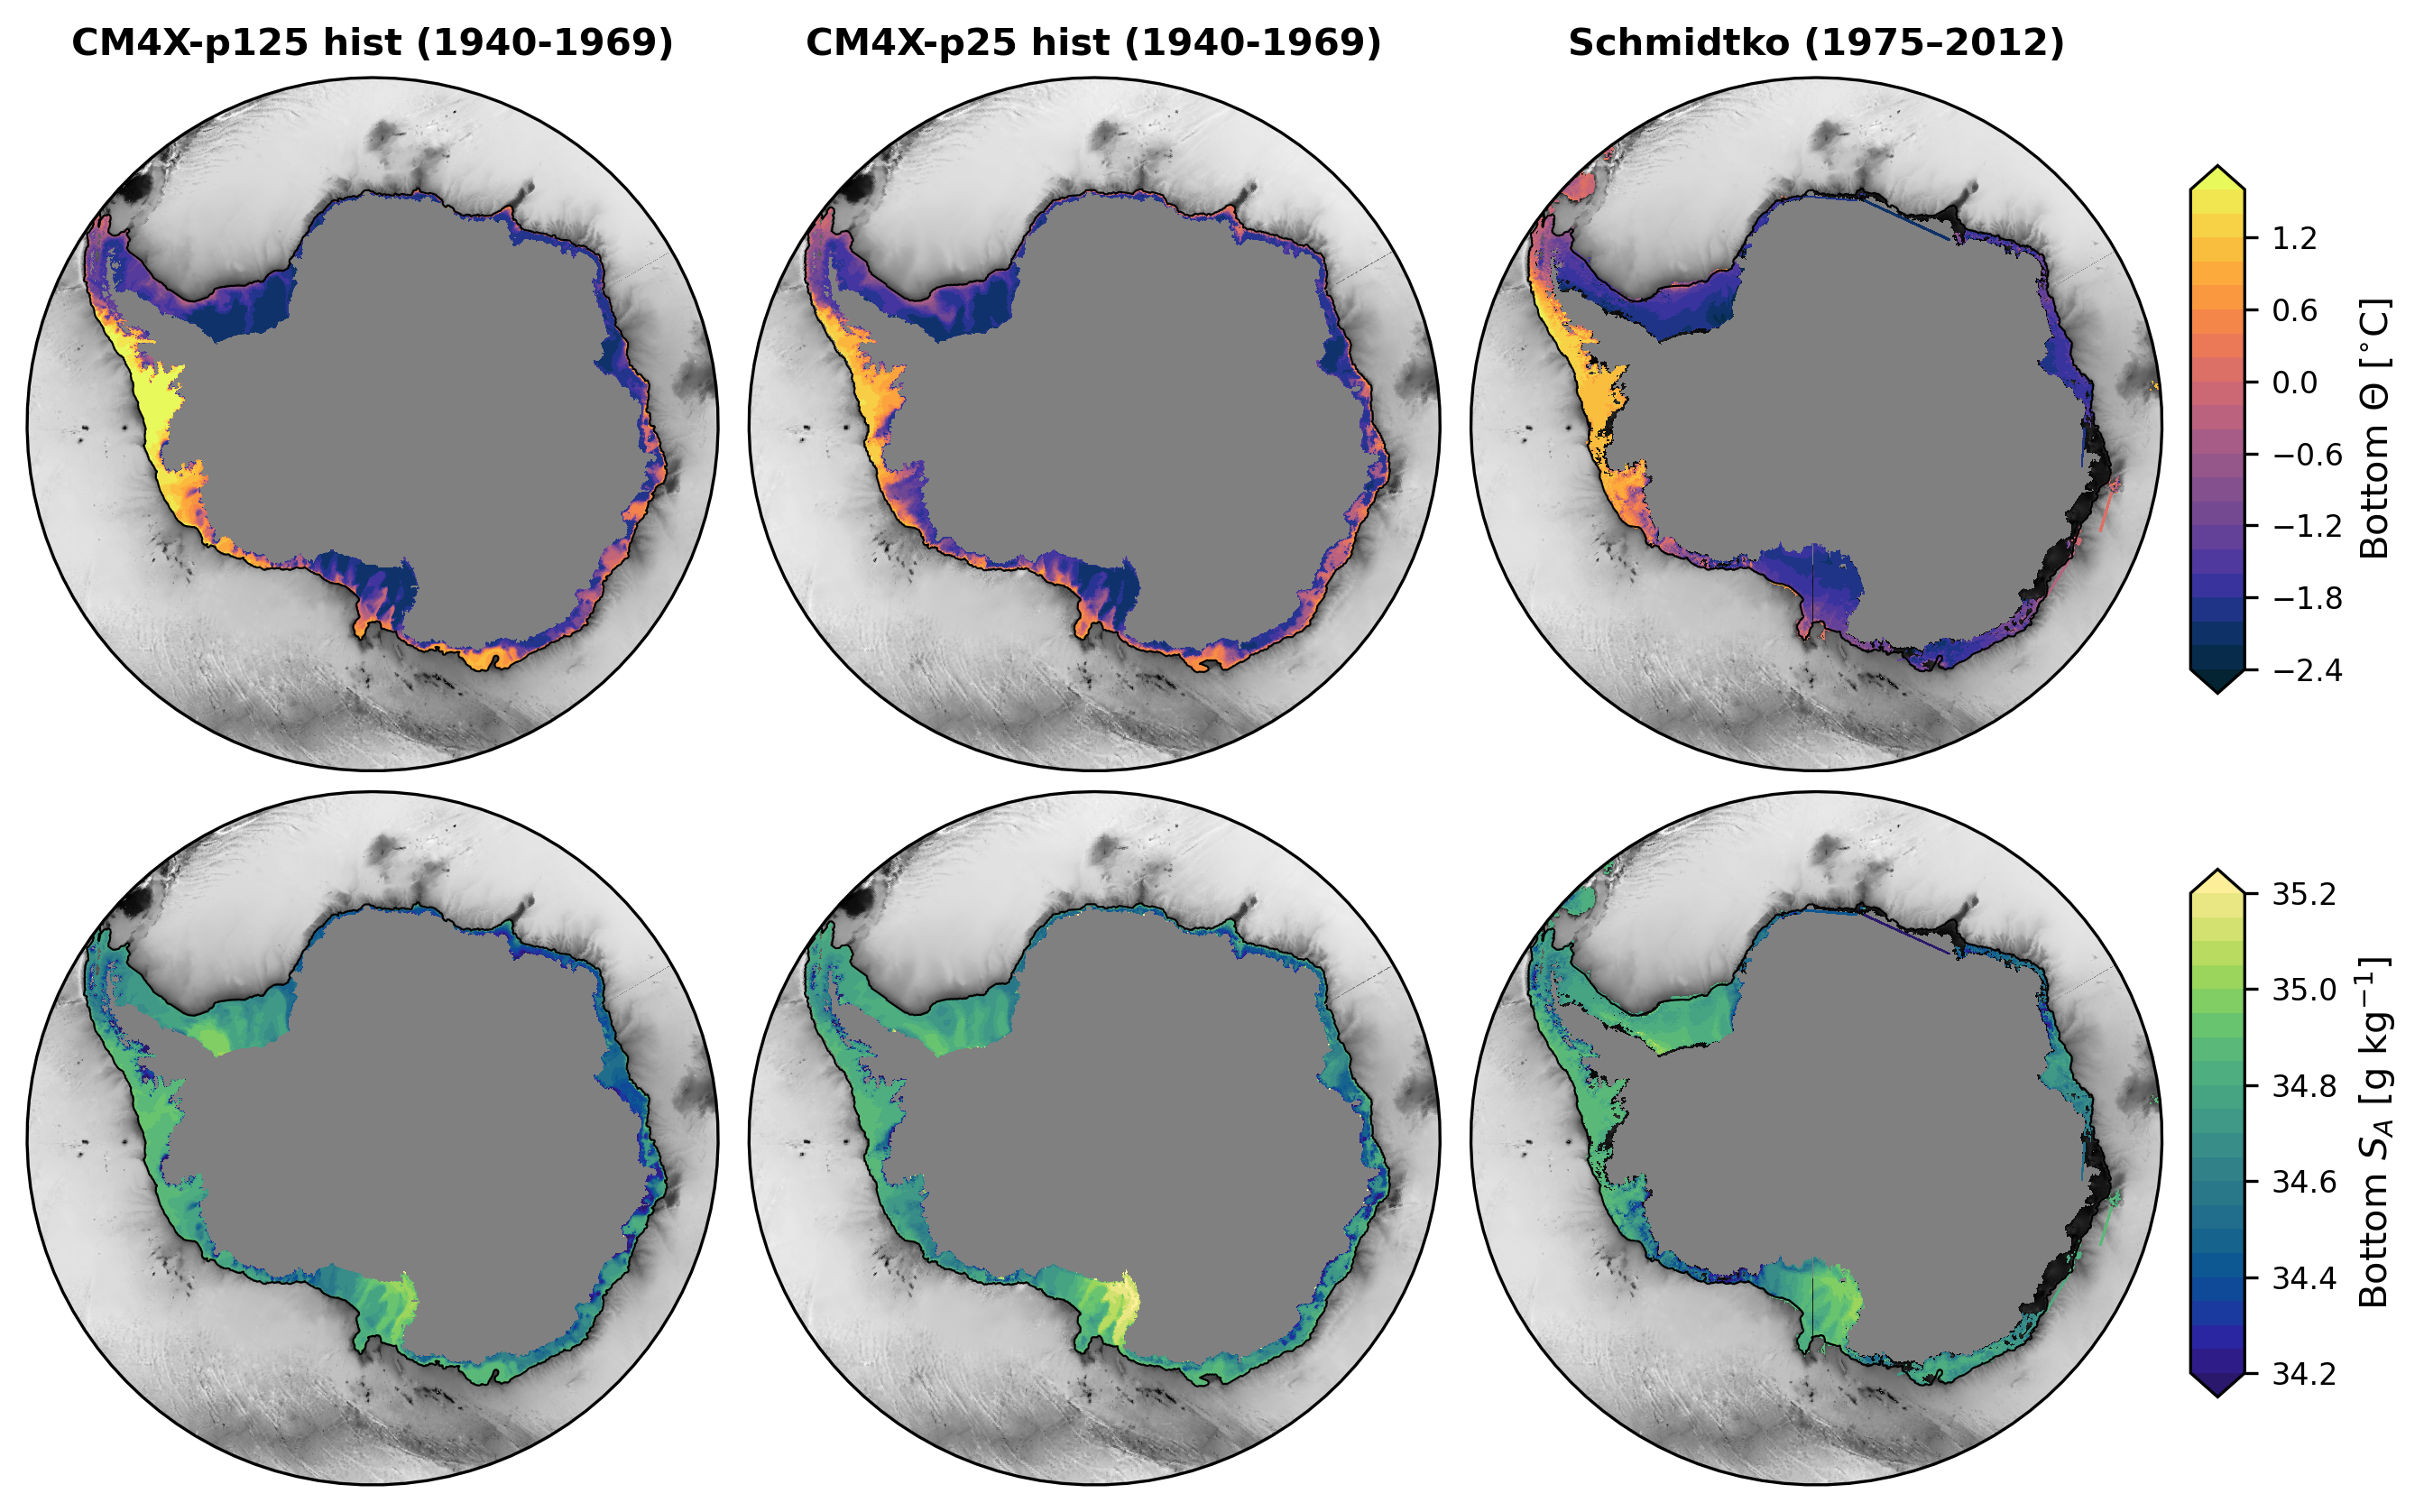

In [21]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10,6.5),
                        subplot_kw=dict(projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='grey'))
fig.subplots_adjust(left=0.1, right=0.89, bottom=0.1, top=0.9, hspace=0.03, wspace=0.04)

for i, mod in enumerate(ddict):
    for j, var in enumerate(list(ddict[mod])[:2]):
        print(mod,var)
        axs[j,i].set_boundary(circle, transform=axs[j,i].transAxes)
        axs[j,i].set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
        
        
        if mod == 'Schmidtko':
            ds = ddict[mod]
            ds[var+'b'] = ds[var]
        else:
            ds = ddict[mod][var]
            ds[var+'b'] = ds['bottom_'+var].sel(time=slice(yr_st,yr_ed)).mean('time')
            
        ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})

        #if mod != 'Schmidtko':
        #    continue
    
        p = ds[var+'b'].where(ds.wet==1).plot(ax=axs[j,i], x='geolon', y='geolat', 
                                              vmin = -2.4 if var=='ct' else 34.2, vmax = 1.6 if var=='ct' else 35.2,
                                              cmap=cmo.thermal if var=='ct' else cmo.haline, levels=21, 
                                              add_labels=False, add_colorbar=False, 
                                              transform=cartopy.crs.PlateCarree(),zorder=1)
        
        if mod == 'Schmidtko':
            ds = ddict['CM4_historical_c192_OM4p125'][var]
            ds = ds.assign_coords({'geolon': ds['geolon'], 'geolat': ds['geolat']})
        
        ds.shlf_mask.plot.contour(ax=axs[j,i], x='geolon', y='geolat', levels=[1000.0],linewidths=0.5, colors='k', 
                                  transform=cartopy.crs.PlateCarree(),zorder=2)
        ds.deptho.plot(ax=axs[j,i], x='geolon', y='geolat',cmap='Greys_r',add_labels=False, 
                       add_colorbar=False, transform=cartopy.crs.PlateCarree(),zorder=0)
        
        if j == 0:
            axs[j,i].set_title(titstr[i], fontsize=10, fontweight='bold')
            
        if i == 2:
            if var == 'ct':
                cax = fig.add_axes([0.90, 0.55 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(-2.4,1.8,0.6))
                cb.set_label(r'Bottom $\Theta$ [$^{\circ}$C]', fontsize=10)
                cb.ax.tick_params(labelsize=8)
            else:
                cax = fig.add_axes([0.90, 0.15 , 0.02, 0.3])
                cb = fig.colorbar(p, cax=cax, orientation='vertical',ticks=np.arange(34.2,35.4,0.2))
                cb.set_label(r'Bottom $S_{A}$ [g kg$^{-1}$]',fontsize=10)
                cb.ax.tick_params(labelsize=8)

plt.savefig('/work/jet/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

CM4_historical_c192_OM4p125 ct
CM4_historical_c192_OM4p125 sa
CM4_historical_c192_OM4p25 ct
CM4_historical_c192_OM4p25 sa
Schmidtko ct
Schmidtko sa


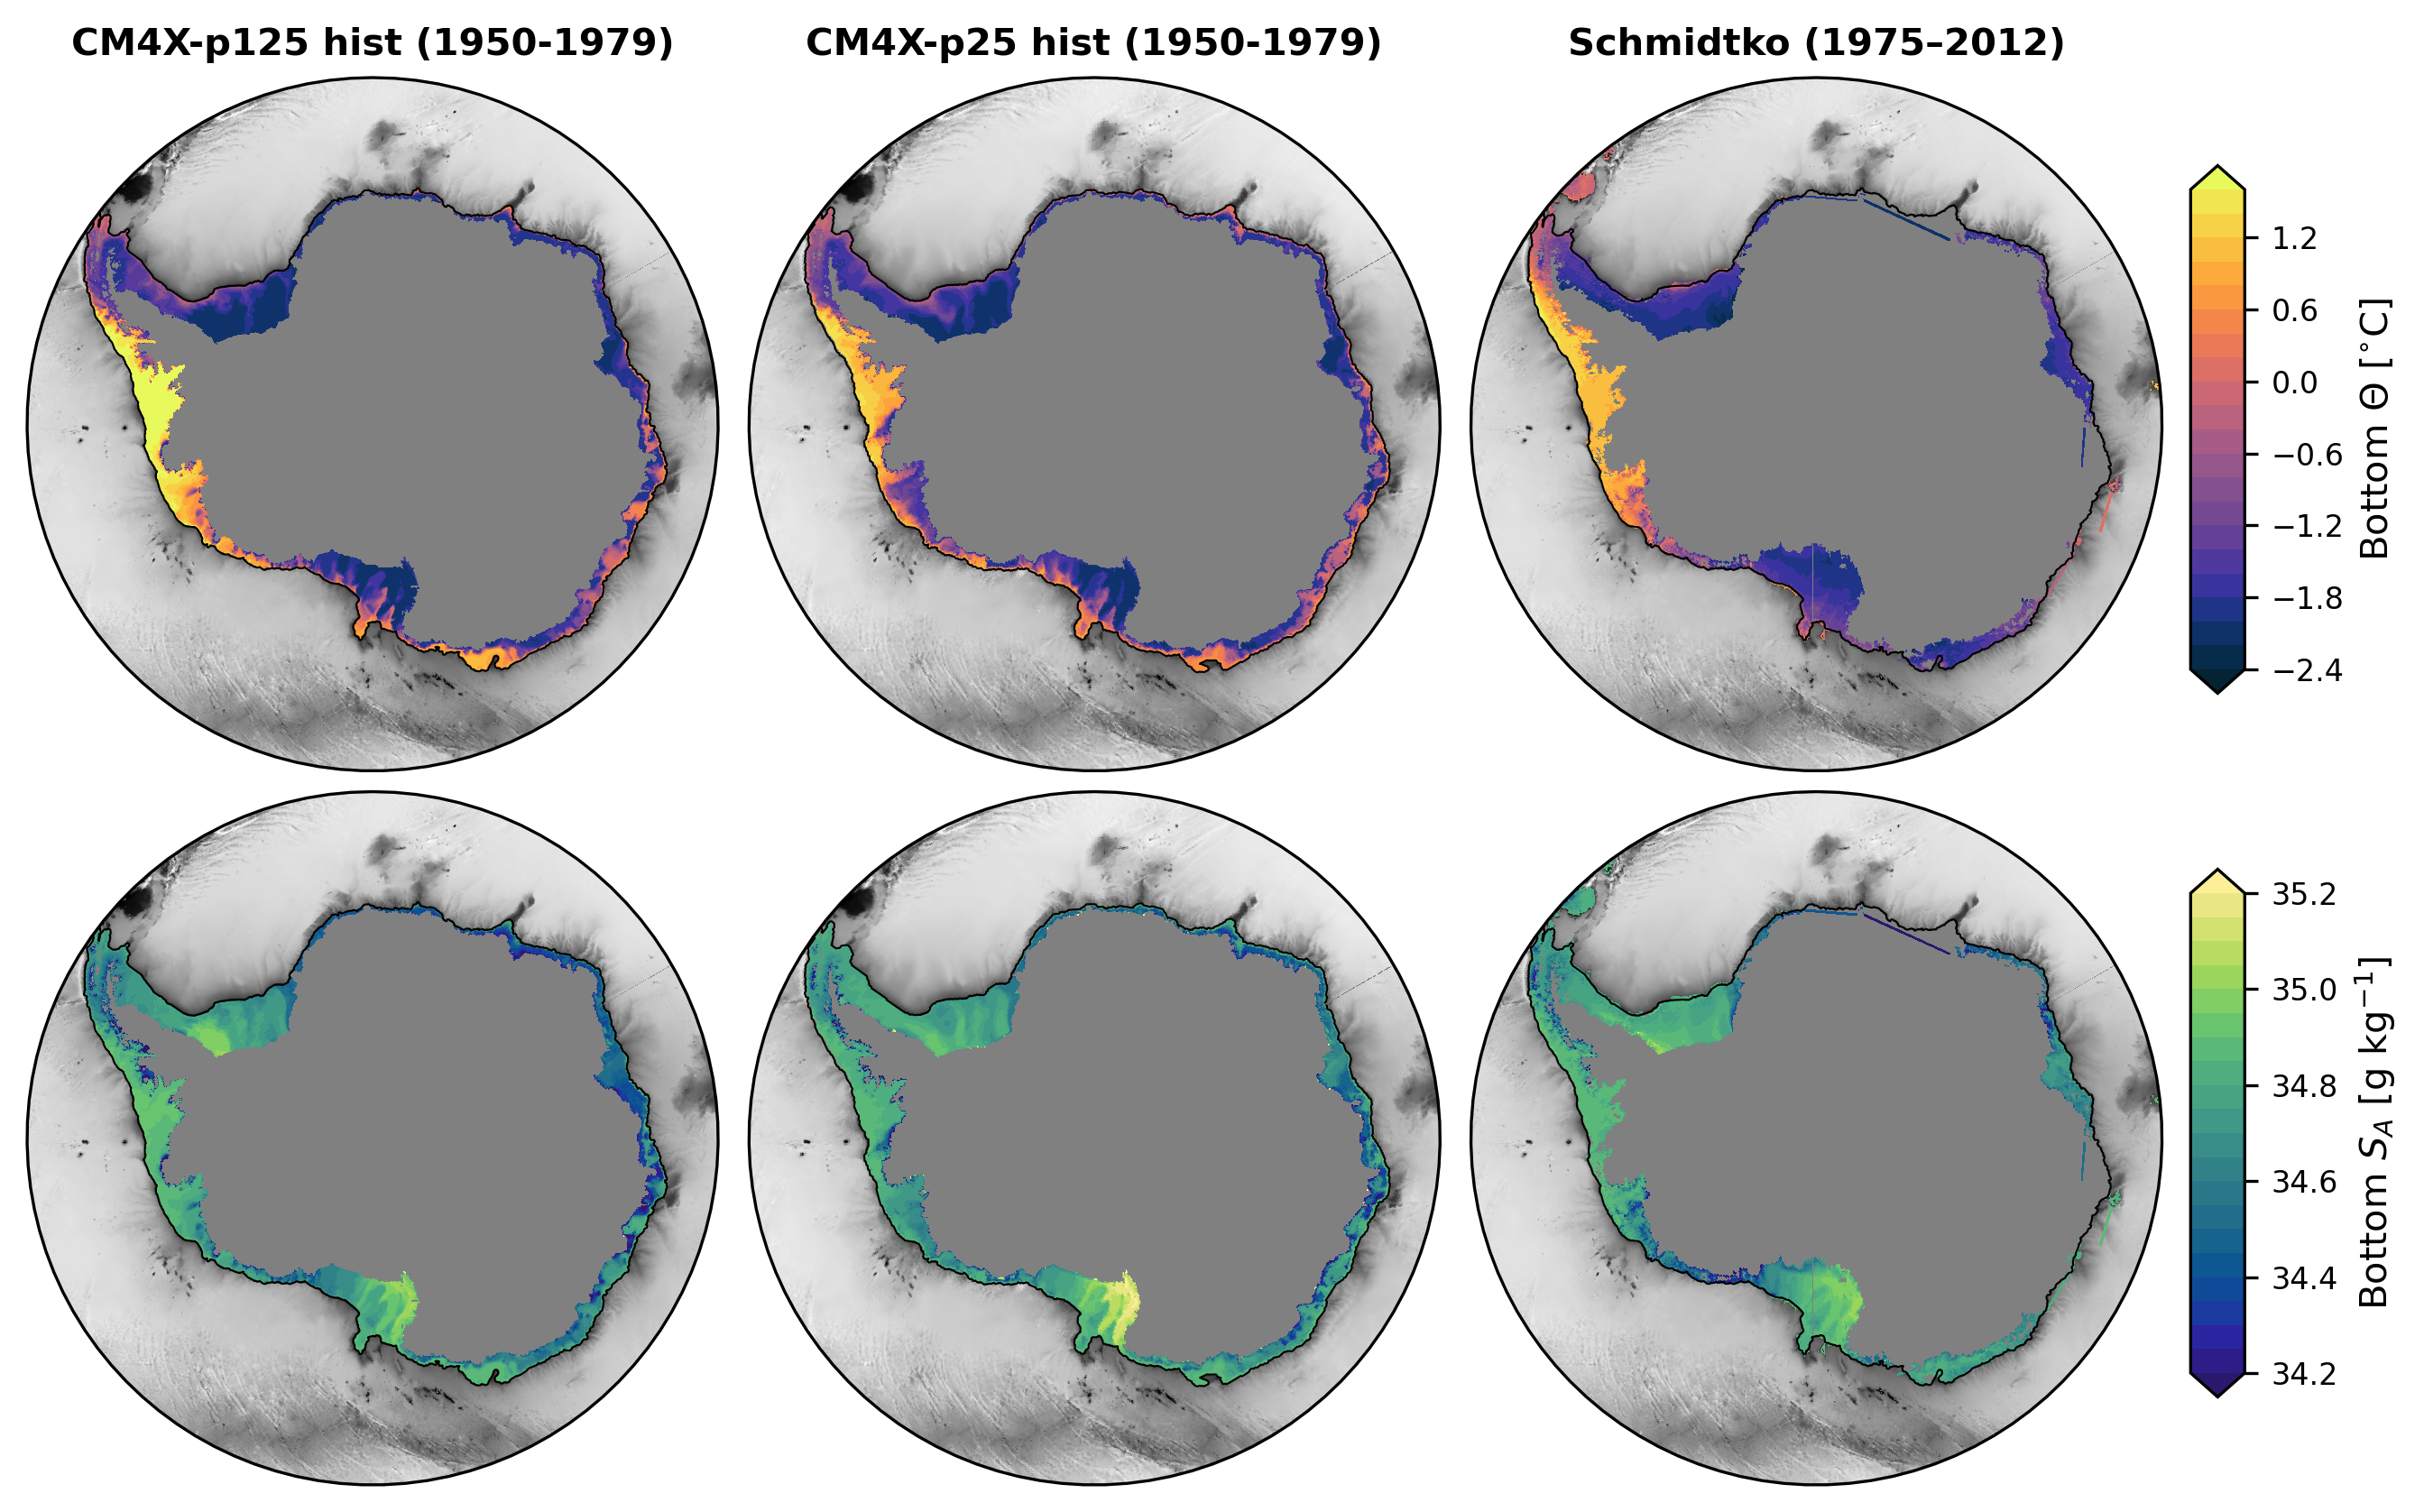